# Pipeline de modélisation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn import tree, ensemble, linear_model, svm, neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score,  roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from joblib import dump, load # pour enregistrer et charger les modèles.

from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

n_coeurs = 4 # spécifie le nombre de coeurs utilisés sur le processeur par les fonctions qui le permettent (logreg, rdf, knn ici)


## 1. Resampling, optimisation et entrainement des modèles

### 1.0 Préparation des données

In [11]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

###### Proportions initiales target:
#RainTomorrow
#0    0.778382
#1    0.221618

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)
# stratify = y assure que la proportion initiale de y se retrouve à l'identique dans les deux échantillons de train et test,
# mais ne permet pas de ré-équilibrer les classes!

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE: pour pouvoir spécifier n_jobs, il faut désormais le faire en instanciant en amont un nearest neighbors compatible, ici NearestNeighbors
nn_smote = NearestNeighbors(n_neighbors = 5, n_jobs = n_coeurs)
smote = SMOTE(random_state = 12, k_neighbors = nn_smote)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))


Classes échantillon SMOTE : {0: 82189, 1: 82189}


In [14]:
# UnderSample grâce à ClusterCentroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)

c:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 1.1 Grid Search

In [12]:
##### Automatisation de GridSearch
# Dictionnaire des modèles et zone de recherche des paramètres.
    # Clé = modèle, valeurs = liste [modèle, dict_paramètres]
    # avec dic_paramètres dictionnaire: clé = hyperparamètre, valeur = liste des valeurs explorées pour l'hyperparamètre correspondant.

dict_grid = {'logreg' : [ linear_model.LogisticRegression(n_jobs = n_coeurs), {"C" : np.logspace(-3, 3, num = 7)} ],

            'dt' : [ tree.DecisionTreeClassifier(),  {"criterion" : ['gini', 'entropy', 'log_loss'],
                                                                               "max_depth" : [5, 10, 50, 100]}],

            'rdf' : [ ensemble.RandomForestClassifier(n_jobs = n_coeurs), {"n_estimators" : [5, 10, 50, 100, 300],
                                                                                   "criterion" :['gini', 'entropy', 'log_loss']}  ],

            'knn' : [ neighbors.KNeighborsClassifier(n_jobs = n_coeurs) , {"n_neighbors" : [10, 25, 50, 100],
                                                          "metric" : ['minkowski', 'manhattan', 'chebyshev'],
                                                          "weights": ['uniform', 'distance']}],

            #'svm' : [ svm.SVC(), {"C" : np.logspace(-2, 2, num = 5),
                                                          # "kernel" :['rbf', 'poly', 'sigmoid'] ,
                                                          # "gamma" : np.logspace(-2, 2, num = 5)} ]
            }


In [4]:
# Recherche et sauvegarde des meilleurs paramètres pour chaque modele:
for model in dict_grid.keys(): #retiré temporairement
    clf = dict_grid[model][0]
    params = dict_grid[model][1]

    grid = GridSearchCV(estimator = clf, param_grid = params, cv = 4, scoring = 'f1_macro', n_jobs = n_coeurs)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    print(str(model)+" best params:", best_params)

    # Sauvegarde du grid search par modèle. ADRESSE A MODIFIER EN FONCTION DU DF
    dump(grid, '../../../../models/saves/grid_saves/grid_'+str(model)+'.joblib')

logreg best params: {'C': 0.1}
dt best params: {'criterion': 'gini', 'max_depth': 10}
rdf best params: {'criterion': 'gini', 'n_estimators': 300}
knn best params: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


### 1.2 Entrainement des modèles et rapport

In [13]:
# Chargement des grid: ADRESSE A MODIFIER EN FONCTION DU DF
grid_logreg = load('../../../../models/saves/grid_saves/grid_logreg.joblib')
grid_dt = load('../../../../models/saves/grid_saves/grid_dt.joblib')
grid_rdf = load('../../../../models/saves/grid_saves/grid_rdf.joblib')
grid_knn = load('../../../../models/saves/grid_saves/grid_knn.joblib')
#grid_svm = load('../../../../models/saves/grid_saves/grid_svm.joblib')

In [14]:
# Définition d'un dictionnaire pour appeler dans la fonction report, avec les best params de GridSearchCV
models = {"logreg" : linear_model.LogisticRegression(C = grid_logreg.best_params_['C'], n_jobs = n_coeurs),
          "dt"  : tree.DecisionTreeClassifier(criterion =  grid_dt.best_params_['criterion'], max_depth =  grid_dt.best_params_['max_depth']),
          "rdf" : ensemble.RandomForestClassifier(n_estimators =  grid_rdf.best_params_['n_estimators'], criterion =  grid_rdf.best_params_['criterion'], n_jobs = n_coeurs),
          "knn" : neighbors.KNeighborsClassifier(n_neighbors =  grid_knn.best_params_['n_neighbors'], metric = grid_knn.best_params_['metric'], n_jobs = n_coeurs)}
          #"svm" : svm.SVC(kernel = grid_svm.best_params_['kernel'], C =  grid_svm.best_params_['C'], gamma =  grid_svm.best_params_['gamma'])}

In [15]:
def report_df(model, sampling):
    # Cette fonction entraine le modèle choisi sur les données data et target (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
        
    # Définition de X_train et y_train en fonction du choix du sampling: 
    if sampling == 'SMOTE':
        X_train = X_sm
        y_train = y_sm
    elif sampling == 'CC':
        X_train = X_cc
        y_train = y_cc
    
    clf = models[model]
    clf.fit(X_train, y_train)
    
    # Sauvegarde du modèle: # ADRESSE A MODIFIER
    dump(clf, '../../../../models/saves/model_saves/save_' + str(model) +'_'+ str(sampling) + '.joblib')
    
    # Prédiction et évaluation:
    y_pred_train = clf.predict(X_train)
    #conf_mat_train = pd.crosstab(y_train,y_pred_train, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep_train = pd.DataFrame.from_dict(classification_report(y_train, y_pred_train, output_dict=True, digits = 2)).T    # création au format df
        
    y_pred_test = clf.predict(X_test)
    #conf_mat_test = pd.crosstab(y_test,y_pred_train, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep_test = pd.DataFrame.from_dict(classification_report(y_test, y_pred_test, output_dict=True, digits = 2)).T    # création au format df
    
    # Enregistrement des résultats sur l'ensemble train:
    acc_train    = class_rep_train['precision'][2]
    prec_0_train = class_rep_train['precision'][0]
    rec_0_train  = class_rep_train['recall'][0]
    f1_0_train   = class_rep_train['f1-score'][0]
    prec_1_train = class_rep_train['precision'][1]
    rec_1_train  = class_rep_train['recall'][1]
    f1_1_train   = class_rep_train['f1-score'][1]
    f1_macro_avg_train = class_rep_train['f1-score'][3]
    f1_weighted_avg_train = class_rep_train['f1-score'][4]
    
    # Enregistrement des résultats sur l'ensemble test:
    acc_test    = class_rep_test['precision'][2]
    prec_0_test = class_rep_test['precision'][0]
    rec_0_test  = class_rep_test['recall'][0]
    f1_0_test   = class_rep_test['f1-score'][0]
    prec_1_test = class_rep_test['precision'][1]
    rec_1_test  = class_rep_test['recall'][1]
    f1_1_test   = class_rep_test['f1-score'][1]
    f1_macro_avg_test = class_rep_test['f1-score'][3]
    f1_weighted_avg_test = class_rep_test['f1-score'][4]
 
    # Résumé des résultats arrondis et pourcentisés dans un dictionnaire:
    dict = {'Modele' :         [model,                               model                             ],
            'Sampling' :       [sampling,                            sampling                          ], 
            'Evaluation' :     ['train',                             'test'                            ],
            'accuracy' :       [round(acc_train*100, 1),             round(acc_test*100, 1)            ],   
            'precision_0 ':    [round(prec_0_train*100, 1),          round(prec_0_test*100, 1)         ],
            'recall_0 ':       [round(rec_0_train*100, 1),           round(rec_0_test*100, 1)          ],
            'f1_0':            [round(f1_0_train*100, 1),            round(f1_0_test*100, 1)           ],
            'precision_1':     [round(prec_1_train*100, 1),          round(prec_1_test*100, 1)         ],
            'recall_1':        [round(rec_1_train*100, 1),           round(rec_1_test*100, 1)          ],
            'f1_1':            [round(f1_1_train*100, 1),            round(f1_1_test*100, 1)           ],
            'f1_macro_avg' :   [round(f1_macro_avg_train*100, 1),    round(f1_macro_avg_test*100, 1)   ],
            'f1_weighted_avg': [round(f1_weighted_avg_train*100, 1), round(f1_weighted_avg_test*100, 1)]
                                }
    df = pd.DataFrame.from_dict(dict)
   
    # Sortie:
    return df

In [15]:
# Création d'un df avec les résultats des différents modèles:

dict_report = {}
keyList = ['Modele','Sampling', 'Evaluation', 'accuracy', 'precision_0 ', 'recall_0 ', 'f1_0', 'precision_1', 'recall_1', 'f1_1', 'f1_macro_avg' ,'f1_weighted_avg']
dict_report = {key: [] for key in keyList}
df_report = pd.DataFrame.from_dict(dict_report)

for model in models:
    for sampling in ['SMOTE', 'CC']:
        df_report = pd.concat([df_report, report_df(model, sampling)], axis = 0) # utilise la fonction report_df précédente.

# A MODIFIER
df_report.to_csv('../../../../models/saves/reports/report.csv')
df_report

,Modele,Sampling,Evaluation,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,f1_macro_avg,f1_weighted_avg
0,logreg,SMOTE,train,78.9,78.3,79.8,79.1,79.4,77.9,78.7,78.9,78.9
1,logreg,SMOTE,test,79.5,92.5,80.1,85.9,52.5,77.2,62.5,74.2,80.7
0,logreg,CC,train,76.4,76.0,77.0,76.5,76.7,75.7,76.2,76.4,76.4
1,logreg,CC,test,78.9,92.1,79.7,85.5,51.6,76.1,61.5,73.5,80.1
0,dt,SMOTE,train,83.1,81.5,85.7,83.5,84.9,80.6,82.7,83.1,83.1
1,dt,SMOTE,test,81.2,90.6,84.6,87.5,56.2,69.1,62.0,74.7,81.8
0,dt,CC,train,82.7,85.0,79.5,82.2,80.8,86.0,83.3,82.7,82.7
1,dt,CC,test,67.4,92.7,63.0,75.0,38.9,82.5,52.8,63.9,70.1
0,rdf,SMOTE,train,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,rdf,SMOTE,test,85.9,90.7,91.2,91.0,68.6,67.1,67.8,79.4,85.8


c:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


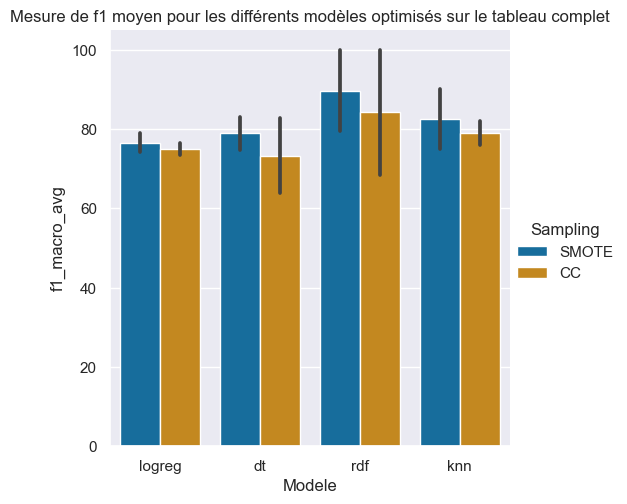

In [16]:
# Comparaison des différents modèles selon le f1_weighted_score:
df_report = pd.read_csv('../../../../models/saves/reports/report.csv')
sns.catplot(data = df_report, x = 'Modele', y = 'f1_macro_avg', hue = 'Sampling', kind = 'bar')
plt.title("Mesure de f1 moyen pour les différents modèles optimisés sur le tableau complet")
plt.show()

### 1.3 Chargement des modèles

In [17]:
# Chargement des modèles: ADRESSE A MODIFIER EN FONCTION DU DF
logreg = load('../../../../models/saves/model_saves/save_logreg_SMOTE.joblib')
dt = load('../../../../models/saves/model_saves/save_dt_SMOTE.joblib')
rdf = load('../../../../models/saves/model_saves/save_rdf_SMOTE.joblib')
knn = load('../../../../models/saves/model_saves/save_knn_SMOTE.joblib')
#grid_svm = load('../../../../models/saves/grid_saves/grid_svm.joblib')

### 1.4 Matrices de confusion

In [20]:
def report(model: str,
           evaluation: str):
    # Cette fonction entraine le modèle choisi sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report

    # Instanciation et entrainement du modèle:
    X_train = X_sm
    y_train = y_sm
    clf = models[model]
    clf.fit(X_train, y_train)

    # Prédiction et évaluation:
    if evaluation == 'train':
        y_train_pred = clf.predict(X_train)
        conf_mat = pd.crosstab(y_train,y_train_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_train, y_train_pred, output_dict=True, digits = 2)).T    # création au format df
    else:
        y_test_pred = clf.predict(X_test)
        conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df

    # Affichage de la matrice de confusion et du rapport de classification:
    df_cm = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df_cr = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')

    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)

    # Création du titre en fonction du modèle:
    title = 'Rapport pour'+ ' ' + str(model) +' sur ' + str(evaluation)

    # Pour afficher au format df
    display_html(title + df_cm._repr_html_()+df_cr._repr_html_(), raw=True)

     # Enregistrement des résultats:
    acc    = class_rep['precision'][2]
    prec_0 = class_rep['precision'][0]
    rec_0  = class_rep['recall'][0]
    f1_0   = class_rep['f1-score'][0]
    prec_1 = class_rep['precision'][1]
    rec_1  = class_rep['recall'][1]
    f1_1   = class_rep['f1-score'][1]
    f1_macro_avg = class_rep['f1-score'][3]
    f1_weighted_avg = class_rep['f1-score'][4]

    # Résumé des résultats arrondis et pourcentisés dans un dictionnaire:
    dict = {'Modele' : model,
            'Evaluation' : evaluation,
            'accuracy' :   round(acc*100, 1),
            'precision_0 ': round(prec_0*100, 1),
            'recall_0 ':    round(rec_0*100, 1),
            'f1_0':         round(f1_0*100, 1),
            'precision_1': round(prec_1*100, 1),
            'recall_1':    round(rec_1*100, 1),
            'f1_1':         round(f1_1*100, 1),
            'f1_macro_avg' : round(f1_macro_avg*100, 1),
            'f1_weighted_avg': round(f1_weighted_avg*100, 1)}

# Remarque: j'ai un problème: le df de classification report afffiche beaucoup trop de décimales à mon goût, contrairement au classification report en txt.
# J'ai essayé plusieurs façons d'arrondir le résultat, mais cela ne marche pas... j'aimerai que cela s'affiche avec deux chiffres après la virgules seulement,
# ce serait plus lisbile.

In [21]:
report('logreg', 'train')

Rapport pour logreg sur train
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 65614 
 16575 
 
 
 1 
 18164 
 64025 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.783189 
 0.798331 
 0.790687 
 82189.000000 
 
 
 1 
 0.794355 
 0.778997 
 0.786601 
 82189.000000 
 
 
 accuracy 
 0.788664 
 0.788664 
 0.788664 
 0.788664 
 
 
 macro avg 
 0.788772 
 0.788664 
 0.788644 
 164378.000000 
 
 
 weighted avg 
 0.788772 
 0.788664 
 0.788644 
 164378.000000

In [22]:
report('logreg', 'test')

Rapport pour logreg sur test
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 21830 
 5567 
 
 
 1 
 1867 
 5933 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.921214 
 0.796803 
 0.854503 
 27397.000000 
 
 
 1 
 0.515913 
 0.760641 
 0.614819 
 7800.000000 
 
 
 accuracy 
 0.788789 
 0.788789 
 0.788789 
 0.788789 
 
 
 macro avg 
 0.718563 
 0.778722 
 0.734661 
 35197.000000 
 
 
 weighted avg 
 0.831395 
 0.788789 
 0.801387 
 35197.000000

Il y a clairement de l'overfitting sur la classe positive 1: Yes

### 1.5 Résultats globaux

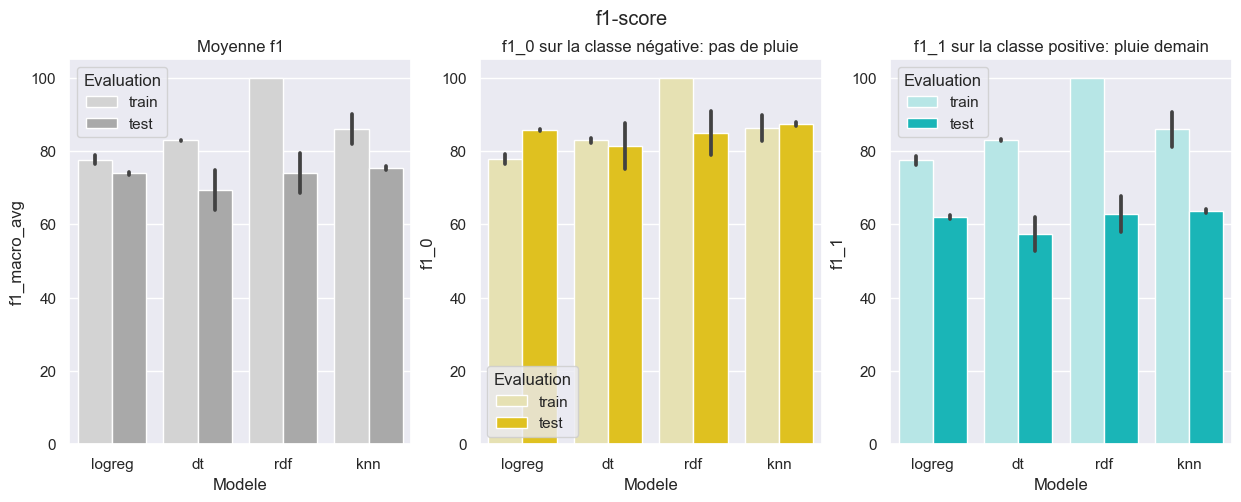

In [22]:
df_report = pd.read_csv('../../../../models/saves/reports/report.csv')
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('f1-score')

sns.barplot(ax = axes[0], data = df_report, x = 'Modele', y = 'f1_macro_avg', hue = 'Evaluation', palette= ['lightgrey', 'darkgrey'])
axes[0].set_title("Moyenne f1")

sns.barplot(ax = axes[1],data = df_report, x = 'Modele', y = 'f1_0', hue = 'Evaluation', palette=['palegoldenrod', 'gold'])
axes[1].set_title("f1_0 sur la classe négative: pas de pluie")

sns.barplot(ax = axes[2],data = df_report, x = 'Modele', y = 'f1_1', hue = 'Evaluation', palette=['paleturquoise', 'darkturquoise'])
axes[2].set_title("f1_1 sur la classe positive: pluie demain")

plt.show()

## 2. Essai de rééquilibrage sur logreg via la feature selection:

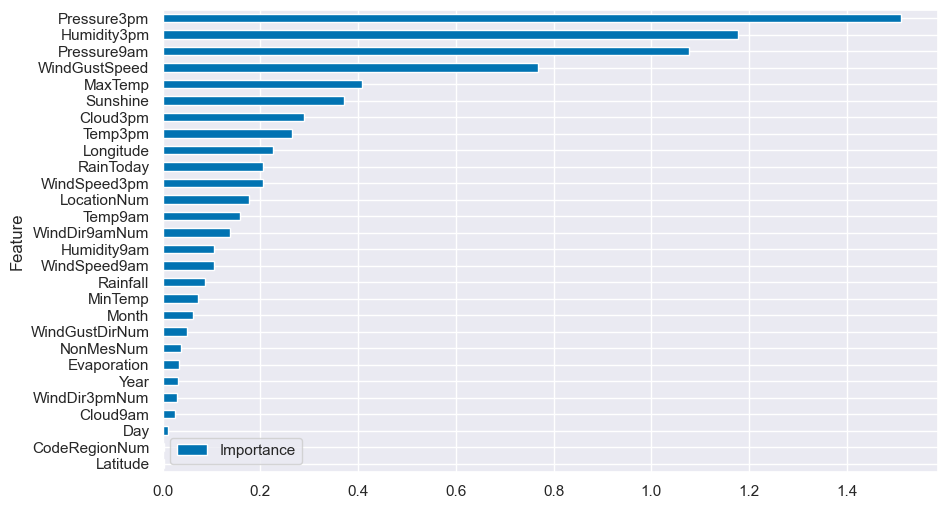

In [23]:
# Features importances pour logreg
# https://forecastegy.com/posts/feature-importance-in-logistic-regression/

logreg_best = load('../../../../models/saves/model_saves/save_logreg_SMOTE.joblib')

coefficients = logreg_best.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

feature_importance = feature_importance.sort_values('Importance', ascending=True, ignore_index = True).copy()

In [25]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE
smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# Recréation des df pour pouvoir enlever les colonnes avec la méthode .drop:
X_train_df = pd.DataFrame(X_sm, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

dict_f1 = {}
keyList = ['NFeatsRemoved',  'f1_0_train', 'f1_1_train', 'f1_0_test', 'f1_1_test']
dict_f1 = {key: [] for key in keyList}

grid_logreg = load('../../../../models/saves/grid_saves/grid_logreg.joblib')

for i in range(feature_importance.shape[0]-1):

    # On enlève une feature et on convertit en numpy array::
    X_train = X_train_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()
    X_test = X_test_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()

    # Entrainement du modèle:
    y_train = y_sm
    clf = linear_model.LogisticRegression(C = grid_logreg.best_params_['C'], n_jobs = n_coeurs)
    clf.fit(X_train, y_train)

    # Prédiction:
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # Evaluation:
    f1_0_test = f1_score(y_test, y_pred_test, pos_label = 0)
    f1_1_test = f1_score(y_test, y_pred_test, pos_label = 1)
    f1_0_train = f1_score(y_train, y_pred_train, pos_label = 0)
    f1_1_train = f1_score(y_train, y_pred_train, pos_label = 1)
    #f1_wavg = f1_score(y_test, y_pred, average = 'weighted')

    # Enregistrement
    dict_f1['NFeatsRemoved'].append(i+1)
    dict_f1['f1_0_train'].append(f1_0_train)
    dict_f1['f1_1_train'].append(f1_1_train)
    dict_f1['f1_0_test'].append(f1_0_test)
    dict_f1['f1_1_test'].append(f1_1_test)
    #dict_f1['f1_weighted_avg'].append(f1_wavg[2])

df_f1 = pd.DataFrame.from_dict(dict_f1)
df_f1.to_csv('../../../../models/saves/reports/logreg_feats_removed.csv')

c:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


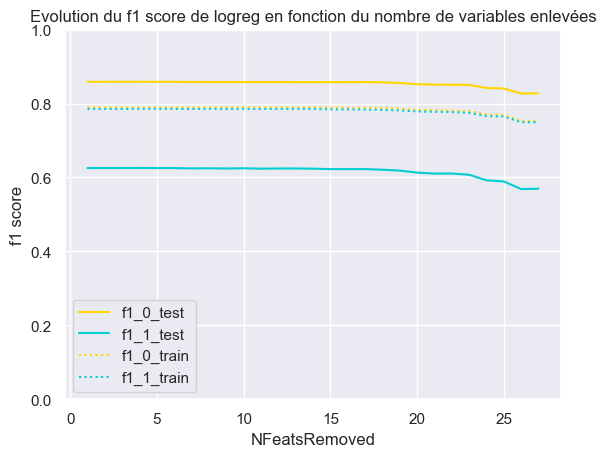

In [24]:
df_f1 = pd.read_csv('../../../../models/saves/reports/logreg_feats_removed.csv')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_test', label = 'f1_0_test', c = 'gold')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_test', label = 'f1_1_test', c = 'darkturquoise')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_train', label = 'f1_0_train', c = 'gold', linestyle = 'dotted')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_train', label = 'f1_1_train', c = 'darkturquoise', linestyle = 'dotted')
plt.ylim([0, 1])
plt.ylabel('f1 score')
plt.title("Evolution du f1 score de logreg en fonction du nombre de variables enlevées")
plt.legend()
plt.show()

In [28]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE
smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

c:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


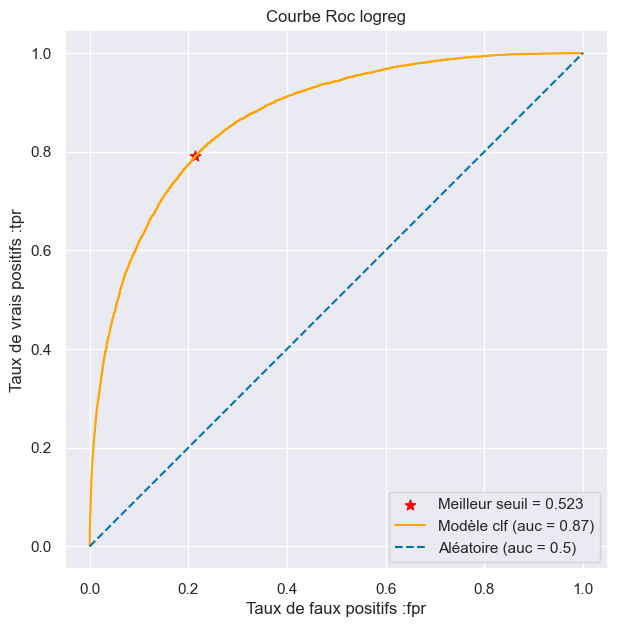

Report logreg 
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     27397
           1       0.54      0.75      0.63      7800

    accuracy                           0.80     35197
   macro avg       0.73      0.79      0.75     35197
weighted avg       0.84      0.80      0.81     35197

[[22349  5048]
 [ 1915  5885]]


In [25]:
logreg = load('../../../../models/saves/model_saves/save_logreg_SMOTE.joblib')
# On fait la prediction sur test:
preds = logreg.predict_proba(X_test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2)
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y

#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe Roc logreg')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report logreg", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: C'est assez mauvais: la précision de la classe positive laisse trop à désirer.

## 3. Essai de rééquilibrage sur RdF via feature selection

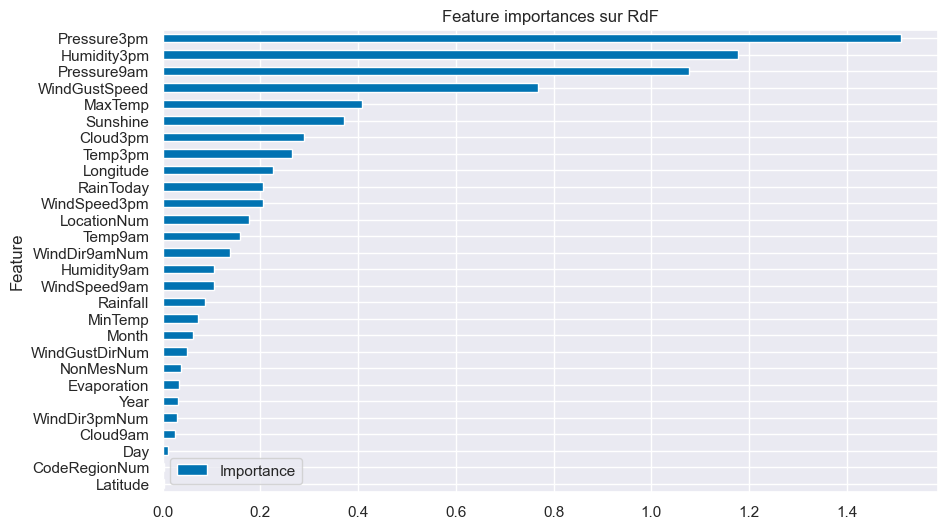

In [26]:
# Features importances pour rdf:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

rdf_best = load('../../../../models/saves/model_saves/save_rdf_SMOTE.joblib')

coefficents = rdf_best.feature_importances_
feature_importance = pd.DataFrame({'Feature' : X.columns, 'Importance' : np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending = True)
feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (10, 6))
plt.title('Feature importances sur RdF')
plt.show()

feature_importance = feature_importance.sort_values('Importance', ascending=True, ignore_index = True).copy()


In [28]:
feature_importance.to_csv('../../../../models/saves/reports/rdf_feats_importances.csv', index = False)

In [32]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE
smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# Recréation des df pour pouvoir enlever les colonnes avec la méthode .drop:
X_train_df = pd.DataFrame(X_sm, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

dict_f1 = {}
keyList = ['NFeatsRemoved',  'f1_0_train', 'f1_1_train', 'f1_0_test', 'f1_1_test']
dict_f1 = {key: [] for key in keyList}

grid_rdf= load('../../../../models/saves/grid_saves/grid_rdf.joblib')
rdf_best = load('../../../../models/saves/model_saves/save_rdf_SMOTE.joblib')

for i in range(feature_importance.shape[0]-1):

    # On enlève une feature et on convertit en numpy array::
    X_train = X_train_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()
    X_test = X_test_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()

    # Entrainement du modèle:
    y_train = y_sm
    clf = rdf_best
    clf.fit(X_train, y_train)

    # Prédiction:
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # Evaluation:
    f1_0_test = f1_score(y_test, y_pred_test, pos_label = 0)
    f1_1_test = f1_score(y_test, y_pred_test, pos_label = 1)
    f1_0_train = f1_score(y_train, y_pred_train, pos_label = 0)
    f1_1_train = f1_score(y_train, y_pred_train, pos_label = 1)
    #f1_wavg = f1_score(y_test, y_pred, average = 'weighted')

    # Enregistrement
    dict_f1['NFeatsRemoved'].append(i+1)
    dict_f1['f1_0_train'].append(f1_0_train)
    dict_f1['f1_1_train'].append(f1_1_train)
    dict_f1['f1_0_test'].append(f1_0_test)
    dict_f1['f1_1_test'].append(f1_1_test)
    #dict_f1['f1_weighted_avg'].append(f1_wavg[2])

df_f1 = pd.DataFrame.from_dict(dict_f1)
df_f1.to_csv('../../../../models/saves/reports/rdf_feats_removed.csv')

c:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


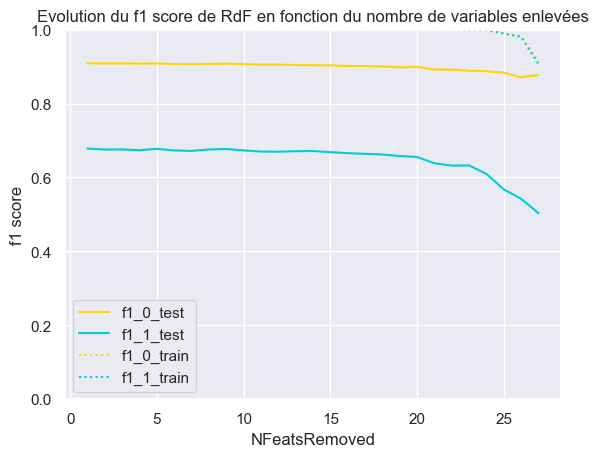

In [33]:
df_f1 = pd.read_csv('../../../../models/saves/reports/rdf_feats_removed.csv')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_test', label = 'f1_0_test', c = 'gold')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_test', label = 'f1_1_test', c = 'darkturquoise')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_train', label = 'f1_0_train', c = 'gold', linestyle = 'dotted')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_train', label = 'f1_1_train', c = 'darkturquoise', linestyle = 'dotted')
plt.ylim([0, 1])
plt.ylabel('f1 score')
plt.title("Evolution du f1 score de RdF en fonction du nombre de variables enlevées")
plt.legend()
plt.show()

In [34]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE
smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

c:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


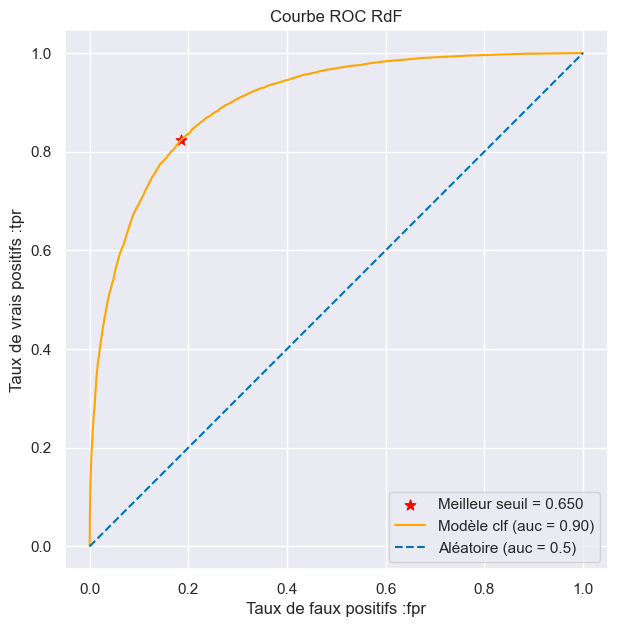

Report RdF 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     27397
           1       0.80      0.50      0.61      7800

    accuracy                           0.86     35197
   macro avg       0.83      0.73      0.76     35197
weighted avg       0.85      0.86      0.85     35197

[[26415   982]
 [ 3937  3863]]


In [35]:
rdf = load('../../../../models/saves/model_saves/save_rdf_SMOTE.joblib')
# On fait la prediction sur test:
preds = rdf.predict_proba(X_test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2)
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y

#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe ROC RdF')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report RdF", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: RdF seuillé obtient le meilleur f1_score, c'est peut être le modèle le plus équilibré à ce jour (14 nov 23, 12h00)